In [3]:
from gnuradio.filter import firdes

from gnuradio import gr
from gnuradio import blocks
from gnuradio.fft import window

from gnuradio.eng_arg import eng_float, intx
from gnuradio import eng_notation
from gnuradio import soapy

In [4]:
#https://joshisanerd.com/projects/sdr_snippets/gnuradio_and_ipython//0%20First%20Attempt.html

tb = gr.top_block()
sample_rate = 1024000
center_freq_Hz = 84000000

N = int(1e6)

stream_args = ''
tune_args = ['']
settings = ['']
dev = 'driver=rtlsdr'

soapy_rtlsdr_source_0 = soapy.source(dev, "fc32", 1, '',
                          stream_args, tune_args, settings)
soapy_rtlsdr_source_0.set_sample_rate(0, sample_rate)
soapy_rtlsdr_source_0.set_gain_mode(0, False)
soapy_rtlsdr_source_0.set_frequency(0, center_freq_Hz)
soapy_rtlsdr_source_0.set_frequency_correction(0, 0)
soapy_rtlsdr_source_0.set_gain(0, 'TUNER', 20)


# Let's try to flush out the first bunch of samples
skip_head = blocks.skiphead(gr.sizeof_gr_complex, 1)

# Limit ourselves to N samples
head = blocks.head(gr.sizeof_gr_complex, N)

# And a sink to dump them into
sink = blocks.vector_sink_c()


tb.connect(soapy_rtlsdr_source_0, skip_head, head, sink) # Can use the handy serial connect method here


Found Rafael Micro R820T tuner
[INFO] Opening Generic RTL2832U OEM :: 00000001...
Found Rafael Micro R820T tuner
[R82XX] PLL not locked!


In [5]:
tb.run()
tb.stop()

[INFO] Using format CF32.


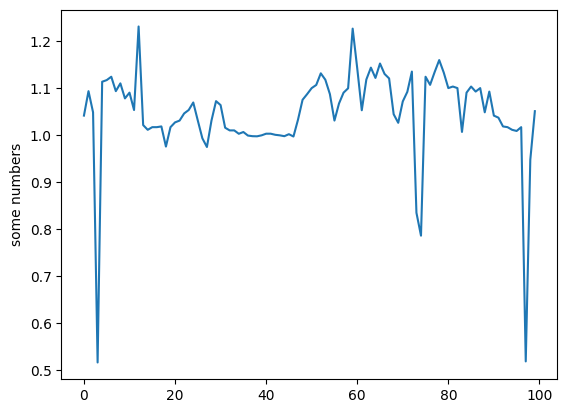

In [6]:
import numpy as np
import matplotlib.pyplot as plt
x = np.array(sink.data())
plt.plot(np.abs(x[0:100]))
plt.xlabel('Sample number')
plt.ylabel('IQ magnitude')
plt.show()

In [7]:
from scipy.signal import spectrogram
(frequencies, times, spectrogram_data)= spectrogram(x, fs=sample_rate, nperseg=128, noverlap=64,return_onesided=False, mode='complex', scaling='density')

# Why fftshift is needed https://github.com/scipy/scipy/issues/5757#issuecomment-259482424
frequencies = np.fft.fftshift(frequencies)
# add the center_freq_Hz to the frequencies to get the actual frequency values
frequencies = frequencies + center_freq_Hz
# convert to MHz
frequencies = frequencies / 1e6

spectrogram_data = np.fft.fftshift(spectrogram_data, axes=0)

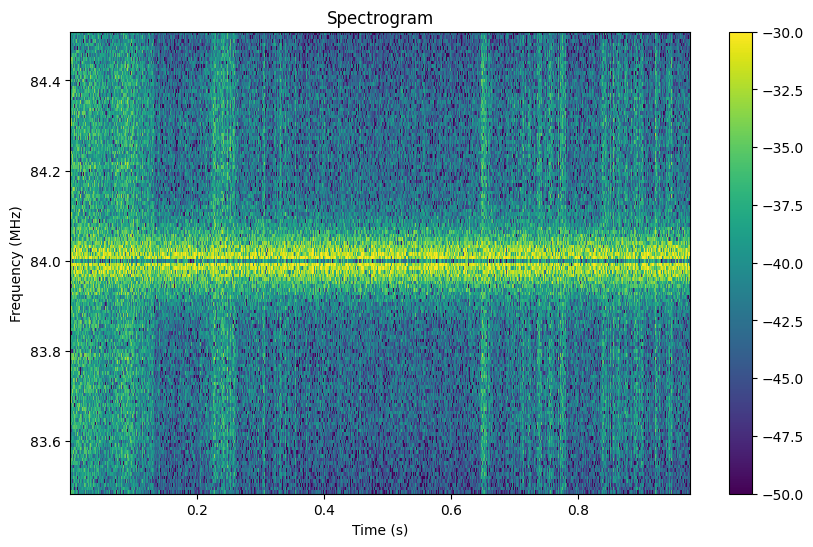

In [14]:
# create a unique colormap to use for the spectrogram plot
cmap = plt.get_cmap('viridis')

fig_width = 10
fig_height = 6

fig = plt.figure(figsize=(fig_width, fig_height))
ax = fig.add_subplot(111)
ph=ax.pcolormesh(times,frequencies, 10*np.log10(np.abs(spectrogram_data)), cmap=cmap)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (MHz)')
#set the colorbar
fig.colorbar(ph, ax=ax)

ax.set_title('Spectrogram')

# set the color bar limits to the range of the data values
#ph.set_clim(np.min(10*np.log10(np.abs(spectrogram_data))), np.max(10*np.log10(np.abs(spectrogram_data))))
ph.set_clim(-50, -30)

plt.show()